In [65]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

In [53]:
# going to use year 2019 winter time (Dec, Jan, Feb)

# urls = ["http://web.mta.info/developers/data/nyct/turnstile/turnstile_190105.txt",
#        "http://web.mta.info/developers/data/nyct/turnstile/turnstile_190112.txt",
#        "http://web.mta.info/developers/data/nyct/turnstile/turnstile_190119.txt"]

# df = pd.read_csv(urls[0], sep= ",")

# for u in urls[1:]:
#     _df = pd.read_csv(u, sep = ",")
# df = pd.concat(df,_df)

url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_190105.txt" # 2019/Jan/5
df = pd.read_csv(url, sep = ",")
df.rename(columns = {df.columns[-1]:"EXITS"},inplace = True)

In [54]:
df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

In [55]:
df.head(50)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/29/2018,03:00:00,REGULAR,6889287,2335920
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/29/2018,07:00:00,REGULAR,6889299,2335936
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/29/2018,11:00:00,REGULAR,6889364,2336038
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/29/2018,15:00:00,REGULAR,6889605,2336101
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/29/2018,19:00:00,REGULAR,6889966,2336173
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/29/2018,23:00:00,REGULAR,6890186,2336219
6,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/30/2018,03:00:00,REGULAR,6890230,2336231
7,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/30/2018,07:00:00,REGULAR,6890237,2336242
8,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/30/2018,11:00:00,REGULAR,6890279,2336288
9,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/30/2018,15:00:00,REGULAR,6890428,2336357


In [62]:
df_date_time = pd.to_datetime(df["DATE"]+" "+df["TIME"])

In [63]:
# combines columns DATE and TIME into one and assign into column DATE_TIME
# and drop the original DATE and TIME column

df["DATE_TIME"] = df_date_time
df.drop(columns = ["DATE","TIME"], inplace = True)
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DESC,ENTRIES,EXITS,DATE_TIME
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,6889287,2335920,2018-12-29 03:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,6889299,2335936,2018-12-29 07:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,6889364,2336038,2018-12-29 11:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,6889605,2336101,2018-12-29 15:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,6889966,2336173,2018-12-29 19:00:00


In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201603 entries, 0 to 201602
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   C/A        201603 non-null  object        
 1   UNIT       201603 non-null  object        
 2   SCP        201603 non-null  object        
 3   STATION    201603 non-null  object        
 4   LINENAME   201603 non-null  object        
 5   DIVISION   201603 non-null  object        
 6   DESC       201603 non-null  object        
 7   ENTRIES    201603 non-null  int64         
 8   EXITS      201603 non-null  int64         
 9   DATE_TIME  201603 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(7)
memory usage: 15.4+ MB


In [76]:
df.sort_values(["DATE_TIME","ENTRIES"]).groupby(["DATE_TIME","ENTRIES"]).count()

C/A  UNIT  SCP  STATION  LINENAME  DIVISION  \
DATE_TIME           ENTRIES                                                
2018-12-29 00:00:00 0         33    33   33       33        33        33   
                    1          9     9    9        9         9         9   
                    2         10    10   10       10        10        10   
                    3          6     6    6        6         6         6   
                    5          3     3    3        3         3         3   
...                          ...   ...  ...      ...       ...       ...   
2019-01-04 23:55:03 101        1     1    1        1         1         1   
2019-01-04 23:55:49 226315     1     1    1        1         1         1   
2019-01-04 23:55:54 47821      1     1    1        1         1         1   
2019-01-04 23:59:35 463        1     1    1        1         1         1   
2019-01-04 23:59:38 715569     1     1    1        1         1         1   

                             DESC  EXITS  
DATE_TIME           ENTRIES               
2018-12-29 00:00:00 0          33     33  
                    1           9      9  
                    2          10     10  
                    3           6      6  
                    5           3      3  
...                           ...    ...  
2019-01-04 23:55:03 101         1      1  
2019-01-04 23:55:49 226315      1      1  
2019-01-04 23:55:54 47821       1      1  
2019-01-04 23:59:35 463         1      1  
2019-01-04 23:59:38 715569      1      1  

[195212 rows x 8 columns]

In [38]:
df.groupby(["C/A","UNIT","SCP","STATION"]).head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/04/2019,00:00:00,REGULAR,7044468,2387700
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/04/2019,04:00:00,REGULAR,7044495,2387706
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/04/2019,08:00:00,REGULAR,7044509,2387740
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/04/2019,12:00:00,REGULAR,7044568,2387757
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/04/2019,16:00:00,REGULAR,7044743,2387774
...,...,...,...,...,...,...,...,...,...,...,...
204046,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,05/04/2019,01:00:00,REGULAR,5554,376
204047,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,05/04/2019,05:00:00,REGULAR,5554,376
204048,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,05/04/2019,09:00:00,REGULAR,5554,376
204049,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,05/04/2019,13:00:00,REGULAR,5554,376


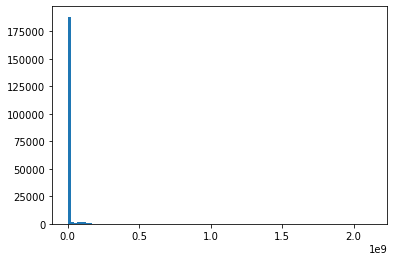

In [39]:
plt.hist(df["ENTRIES"], bins=100);
plt.xlabel = "ENTRIES"

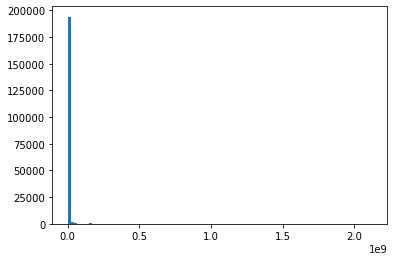

In [40]:
plt.hist(df["EXITS"], bins=100)
plt.xlabel = "EXITS"

<AxesSubplot:xlabel='ENTRIES', ylabel='Count'>

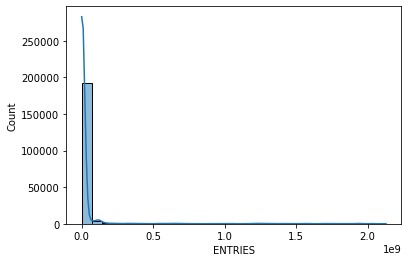

In [46]:
sns.histplot(data = df,x = "ENTRIES", kde = True, bins= 30)

<AxesSubplot:xlabel='EXITS', ylabel='Count'>

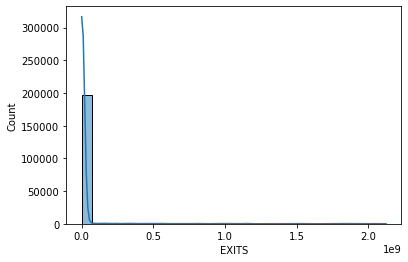

In [47]:
sns.histplot(data = df,x = "EXITS", kde = True, bins = 30)

In [51]:
df.groupby(["STATION","DATE","TIME"])["ENTRIES","EXITS"].count()

<ipython-input-51-70fcb3a950cd>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby(["STATION","DATE","TIME"])["ENTRIES","EXITS"].count()


ENTRIES  EXITS
STATION   DATE       TIME                    
1 AV      05/04/2019 00:00:00       10     10
                     04:00:00       10     10
                     08:00:00       10     10
                     12:00:00       10     10
                     16:00:00       10     10
...                                ...    ...
ZEREGA AV 05/10/2019 05:00:00        6      6
                     09:00:00        6      6
                     13:00:00        6      6
                     17:00:00        6      6
                     21:00:00        6      6

[30060 rows x 2 columns]